# 深入挖掘llama3的从零实现

<center>
    <img src="images/logo.png" width="600px"/>
</center>

本项目是基于 [naklecha/llama3-from-scratch](https://github.com/naklecha/llama3-from-scratch) 的增强版本。在原项目的基础上进行了全面的改进和优化，旨在帮助大家更轻松地理解和掌握llama3模型的实现原理以及详细的推理流程，感谢原作者的贡献 :)
<br><br>
<span style="font-size: 1.2em; font-weight: bold;">
以下是本项目的核心改进点：
</span>


1. **结构优化**  
   重新编排了内容顺序，调整了目录结构，使学习过程更加清晰合理，便于大家循序渐进地理解代码。
   
2. **代码注释**  
   添加了大量详细的代码注释，手把手教你理解每一段代码的作用，即使是初学者也能轻松上手。
   
3. **维度追踪**  
   完整注解了每一步计算中矩阵维度的变化，让你更容易的理解整个流程。
   
4. **原理说明**  
   补充了丰富的原理类说明，大量的细节推导，不仅告诉你“要怎么做”，还深入解释了“为什么要这么做”，帮助你从根本上掌握模型的设计思想。
   
5. **KV-Cache**  
   额外增加了KV-Cache的推导章节，涵盖详细的核心思想、原理推导以及在注意力机制中的应用流程等内容，让你从根源了解KV-Cache的每个细节及思考。
   
6. **双语文档**  
   提供了中英双语的代码文件，原生的中文翻译避免机翻的词不达意。
<br><br>   

<span style="font-size: 1.5em; font-weight: bold;">
下面让我们开始正式的学习过程！
</span>
<br><br>

在这个文件中，我从头开始实现了llama3，一次一个张量和矩阵乘法。
<br>
此外，我将直接从meta为llama3提供的模型文件（Meta-Llama-3-8B）中加载张量，您需要在运行此文件之前下载权重。
这里是下载权重的官方链接：https://llama.meta.com/llama-downloads/
<br><br>
注1：本项目目前实现了基于Huggingface的模型文件下载方式，你将在下面的加载模型章节看到。同样的，你也可以在官网或ModelScope等模型下载源进行自行下载，而无需运行下面的模型下载代码
<br>
注2：本项目使用的是原始模型文件，即下载的模型文件中的"original"文件夹下的模型
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">
    请注意！图中有个小错误：<br>
    <span style="font-size: 0.9em; font-weight: normal;">
        在每个transformer块中，第二次的add的输入应该为feed-forward的输出以及第一次add的输出，而非normalization后的结果。
        <br>
        如果把multi-head self-attention和feed-forward看作是相同的操作（均为特征变换），则两次的 归一化(normalization)-特征变换-残差连接(add) 的形式和过程是一模一样的
    </span>
</span>

<div>
    <img src="images/archi.png"/>
</div>

# 加载模型

让我们首先下载一下指定版本的llama3模型文件（将从Huggingface中进行下载）

注意，如果你已经通过其他方式获取或下载了模型文件，请依旧运行本节的所有单元格（除了 "下载模型文件" 单元格），以避免后续相关库或字段的缺失

In [ ]:
# 如果在 Google Colab 运行此单元格，请安装所需的库
# ! pip install tiktoken blobfile

In [ ]:
# 导入相关库
from pathlib import Path  # 用于从文件路径中获取文件名/模型名
import tiktoken  # openai开发的开源库，用于文本编解码（文本和tokenid的相互转换）
from tiktoken.load import load_tiktoken_bpe  # 加载BPE模型
import torch  # 用于搭建模型和矩阵计算
import json  # 用于加载配置文件
import matplotlib.pyplot as plt  # 用于绘图
from huggingface_hub import login, hf_hub_download  # 使我们可以从 HuggingFace 下载权重

In [ ]:
# 登录 HuggingFace，以便我们可以下载权重
login()

In [ ]:
# 选择模型在什么设备上进行加载和计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # 如果有GPU则运行在GPU上，否则运行在CPU上
print(f"使用设备: {device}")
torch.set_default_device(device)

In [ ]:
# 选择要下载和使用的模型

# 注意，默认推荐的模型为 Meta-Llama-3-8B
# 本项目中的模型架构、超参数等，均是基于该模型进行的分析，不同模型间可能会有一点差异是正常的

# 要从 HuggingFace 获取权重，您需要访问模型的 URL 并请求访问权限。
# 例如，对于模型 Meta-Llama-3-8B，您需要访问 https://huggingface.co/meta-llama/Meta-Llama-3-8B
# 并请求被授予访问权限。

# 选择任何版本或变体的 Llama。
# 您可以选择 3.0、3.1 或 3.2 版本。
# 3.2 版本提供 3B 或 1B 参数大小。
# 您还可以选择 "Instruct" 版本。

# "Instruct" 版本与普通版本有什么区别？
# "Vanilla"（普通版）是尚未对齐的 "基础模型"。
# "Instruct" 版本经过对齐，并且能够回答问题。
# 代码是相同的，唯一的区别是权重的不同，这对学习来说很有意义。

model_path = "Meta-Llama-3-8B"             # https://huggingface.co/meta-llama/Meta-Llama-3-8B

# model_path = "Llama-3.1-8B"                # https://huggingface.co/meta-llama/Llama-3.1-8B

# model_path = "Llama-3.2-3B"                # https://huggingface.co/meta-llama/Llama-3.2-3B
# model_path = "Llama-3.2-1B"                  # https://huggingface.co/meta-llama/Llama-3.2-1B

# model_path = "Meta-Llama-3-8B-Instruct"    # https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct

# model_path = "Llama-3.1-8B-Instruct"       # https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct

# model_path = "Llama-3.2-3B-Instruct"       # https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct
# model_path = "Llama-3.2-1B-Instruct"       # https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct

In [ ]:
# 下载模型文件

repo_id = f"meta-llama/{model_path}"

files = [
    "original/consolidated.00.pth",   # PyTorch 格式的模型权重
    "original/params.json",           # 模型配置
    "original/tokenizer.model",       # 分词器模型
]

for file in files:
    file_path = hf_hub_download(
        repo_id=repo_id,
        filename=file,
        local_dir=f"./{model_path}",
        use_auth_token=True
    )
    print(f"已下载 {file} 到 {file_path}")

In [ ]:
# 此时，我们需要确保 model_path 目录中包含以下 3 个文件：
assert Path(f"{model_path}/original/tokenizer.model").exists()
assert Path(f'{model_path}/original/consolidated.00.pth').exists()
assert Path(f"{model_path}/original/params.json").exists()

## 加载分词器tokenizer

分词器用于将输入的文本字符串切割为子词序列，从而便于输入给模型
<br>
我不打算实现bpe分词器（但andrej karpathy有一个非常干净的实现），链接到他的实现：https://github.com/karpathy/minbpe

<div>
    <img src="images/karpathyminbpe.png" width="600"/>
</div>
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">
加载基于BPE的tokenizer的步骤总结：
</span>

1. 常规词字典加载：加载本地tokenizer模型字典（只包含常规子词，无特殊token）
2. 特殊词字典定义：手动定义特殊tokens（用现成的或基于现成的进行修改）
3. 文本粗分割规则定义：定义文本粗分割的正则表达式（用现成的即可）。输入将经过粗分割（基于正则）和细分割（基于BPE）两步，得到最终的分词结果
4. 创建tokenizer：基于openai开源的tiktoken库创建文本编解码器对象（可以在粗分割结果的基础上进一步基于BPE算法进行分割处理）

In [ ]:
# 加载基于BPE的tokenizer

tokenizer_path = f"{model_path}/original/tokenizer.model"  # 分词器模型的路径

# 常规词典外的特殊token
# 在"Meta-Llama-3-8B/"路径下的'tokenizer.json'和'tokenizer_config.json'的added_tokens字段下都有这些特殊token
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",  # 保留了从0到250的特殊token
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",  # 头部信息的开始，用于标记包裹结构化数据的头部信息，如元数据
            "<|end_header_id|>",  # 头部信息的结束
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn，多轮对话里标记当前轮次对话的结束
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]


# 加载BPE模型（实际是一个字典）
# 一个字典，子词(bytes类型，用utf-8解码)-rank(id)对，128000词，不包含上面的256个特殊token（所以模型的总词典大小是128256）
# 其中rank值是从0递增的序列，用于决定子词单元合并的优先顺序，优先级越高的会优先合并，因此这里的名字是mergeable ranks而非BPE或字典等类似的名字
# 没把特殊token加到字典里应该是出于灵活性考虑，便于面对不同模型架构或任务有不同特殊token时添加特定的token，而且保持字典大小不变
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)


# 创建一个文本编解码器对象
# 其中的pat_str大致分为三个类型：带缩写的单词 & 单词、中文片段、1-3位的数字 & 其他特殊字符
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,  # 编码器名称，便于调试和日志记录使用的不同的编码器
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",  # 用于初步的粗分割文本为token序列的正则表达式
    mergeable_ranks=mergeable_ranks,  # 传入加载的BPE模型
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},  # 添加特殊token-id对的字典
)


# 测试是否创建成功，即编解码器是否能正确运行
print(tokenizer.decode(tokenizer.encode("create tokenizer successed!")))


# 下面是一个案例测试，来测试pat_str粗分割和tokenizer细分割的效果和区别
# pat_str的正则只是提供了一个初步的分割，一些长句子或中文等不会分割，会在tokenizer中进一步基于BPE算法进行细化分割
import regex  # 由于pat_str中用到了Unicode的一些语法，如\p{L}，所以不能用re库

## 创建正则
pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+"
pattern = regex.compile(pat_str)

## 文本切分
text = "Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789."  # 测试文本
re_tokens = pattern.findall(text)  # 使用正则表达式分割字符串
merge_tokens_id = tokenizer.encode(text)  # 使用tokenizer分割字符串
merge_tokens = [tokenizer.decode([i]) for i in merge_tokens_id]  # 将tokenizer分割结果的id序列转换为实际的子词序列

## 结果输出
print("原始字符串:", text)
print("正则分割结果:", re_tokens)
print("tokenizer分割结果:", merge_tokens)
print("tokenizer分割结果id:", list(zip(merge_tokens, merge_tokens_id)))

## 从结果将会看到所有单词的前缀空格都被保留了下来，而非单独一个空格token或将其删除，有利于模型正确理解单词间的边界信息，如例子中的alongwords


_="""
输出结果：

create tokenizer successed!
原始字符串: Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789.
正则分割结果: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这是一个测试', '.', ' alongwords', '.',
               ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
tokenizer分割结果: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这', '是一个', '测试', '.',
                    ' along', 'words', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
tokenizer分割结果id: [('Hello', 9906), (' world', 1917), ('!', 0), (' It', 1102), ("'s", 596), (' a', 264),
                      (' test', 1296), ('.', 13), (' 这', 122255), ('是一个', 122503), ('测试', 82805), ('.', 13),
                      (' along', 3235), ('words', 5880), ('.', 13), (' a', 264), (' long', 1317), (' words', 4339),
                      ('.', 13), (' ', 220), ('123', 4513), (' ', 220), ('456', 10961), (' ', 220), ('789', 16474), ('.', 13)]

"""

create tokenizer successed!
原始字符串: Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789.
正则分割结果: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这是一个测试', '.', ' alongwords', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
tokenizer分割结果: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这', '是一个', '测试', '.', ' along', 'words', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
tokenizer分割结果id: [('Hello', 9906), (' world', 1917), ('!', 0), (' It', 1102), ("'s", 596), (' a', 264), (' test', 1296), ('.', 13), (' 这', 122255), ('是一个', 122503), ('测试', 82805), ('.', 13), (' along', 3235), ('words', 5880), ('.', 13), (' a', 264), (' long', 1317), (' words', 4339), ('.', 13), (' ', 220), ('123', 4513), (' ', 220), ('456', 10961), (' ', 220), ('789', 16474), ('.', 13)]


## 读取模型文件和配置文件

通常，读取模型文件取决于它的模型类是如何编写的以及其中的变量名。
<br>
但是由于我们是从零开始实现llama3，因此我们将每次读取一个张量文件。
<div>
    <img src="images/model.png" width="600"/>
</div>

In [2]:
# 加载模型，一个网络层名称-tensor类型参数的字典
model = torch.load(f"{model_path}/original/consolidated.00.pth", weights_only=False, map_location=device)

# 输出前20层网络名，验证是否正确加载
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [3]:
# 加载配置文件，每个配置的具体含义见下节
with open(f"{model_path}/original/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

### 使用配置文件推断模型的细节

| 配置项 | 配置值 | 含义 |
| ---- | ---- | ---- |
| dim | 4096 | 隐藏层维度，即每个token的向量表示的维度为4096维 |
| n_layers | 32 | 模型的层数，即该模型有32个transformer层，或者说transformer块 |
| n_heads | 32 | 多头注意力的头数，即每个多头注意力块有32个头，所谓的多头即同时使用了多个独立的注意力机制，以捕捉输入数据的不同特征或信息 |
| n_kv_heads | 8 | 键值注意力的头数，用于分组查询注意力GQA，即键值注意力有8个头，而查询有n_heads=32个头，每4个查询头会共享一组键值对 |
| vocab_size | 128256 | 词汇表大小，128000个普通token，256个特殊token |
| multiple_of | 1024 | 隐藏层维度的倍数约束，即限制模型隐藏层维数应为1024的倍数，从而优化计算效率 |
| ffn_dim_multiplier | 1.3 | 前馈网络层的隐藏层维度乘数，用于计算FFN隐藏层维度，计算过程可见对应节 |
| norm_eps | 1e-05 | 层归一化计算中在分母里加的常量，防止除零，保证数值稳定性 |
| rope_theta | 500000.0 | 旋转位置编码RoPE中的基础频率缩放因子，控制位置编码的周期性和分辨率，从而影响模型对不同长度序列和位置关系的捕捉能力 |

<br>

<span style="font-size: 1.2em; font-weight: bold;">
基于上述配置细节，可推断出给定一个输入，attention内部的计算流程为：
</span>
    
<pre>
input(L, 4096) -> query_proj(L, 128, 32)
               -> key_proj(L, 128, 8)
               -> value_proj(L, 128, 8)
                                           -> group_query_attention(L, 128, 32)
                                           -> output_proj(L, 4096)
                                                                                   -> output(L, 4096)
</pre>

In [4]:
# 记录这些配置，后面将逐渐用到
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

# 将输入文本转换为嵌入向量

将字符串形式的文本输入给网络层之前，需要将其转换为向量形式，以进行数学计算。
<br>
需要的流程为：使用分词器将输入文本切分为子词序列 -> 将子词转换为向量表示

## 将文本转换为token id序列
这里我们使用tiktoken（来自openai的库）作为tokenizer
<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [5]:
# 将输入的文本prompt转换为token id序列
prompt = "the answer to the ultimate question of life, the universe, and everything is "  # 输入文本
tokens = [128000] + tokenizer.encode(prompt)  # 做子词切分，并在文本开头加入指示文本开始了的特殊token：<|begin_of_text|>，维度：[17]
print(tokens)  # 查看下切分后的结果
tokens = torch.tensor(tokens)  # 转换为张量类型，便于后续矩阵计算，[17]

# 将token id序列转换为具体的token子词序列，仅作为展示用，实际不需要
prompt_split_as_tokens = [tokenizer.decode([token]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## 将token id序列转换为embedding嵌入向量

很抱歉，这里是这个代码库中我唯一使用了内置神经网络模块的部分
<br>
总之，我们原本的[17x1]token序列现在是[17x4096]，即17个长度为4096的嵌入（每个token一个）
<br><br>
注意：关注这个张量形状的变化，这会让你更容易理解整个流程（我将全程注释形状的变化情况）

<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [6]:
# 创建一个嵌入层网络，用于将离散的token id映射到连续的向量空间
embedding_layer = torch.nn.Embedding(vocab_size, dim)

# 将嵌入层网络的参数替换为llama3中预训练好的参数值
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])

# 使用嵌入层网络，将输入的token id序列转换为向量表示
# 嵌入层网络仅是基于id查字典来找到对应的向量，不涉及token间的交互
# [17] -> [17x4096]
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)  # 默认是float32全精度，这里换成半精度格式，降低内存占用

token_embeddings_unnormalized.shape

torch.Size([17, 4096])

# 构建第一层的transformer块

从下面展示的第一层transformer块所涉及的预训练参数来看，包含了：
1. 两次归一化（attention_norm及ffn_norm）
2. 注意力机制的实现（4个attention.w）
3. 前馈网络层的实现（3个feed_forward.w）
4. （当然还包含两次不需要预训练参数的残差连接操作）

总的来说，一个transformer块中的操作流程如下：
<br>
归一化 -> 多头自注意力 -> 残差连接 -> 归一化 -> 前馈神经网络 -> 残差连接

In [7]:
# 展示第一层transformer块的所有权重参数及形状
for k, v in model.items():
    if not k.startswith('layers'):
        continue
    if k.startswith('layers.1'):
        break
    print(k, v.shape)

layers.0.attention.wq.weight torch.Size([4096, 4096])
layers.0.attention.wk.weight torch.Size([1024, 4096])
layers.0.attention.wv.weight torch.Size([1024, 4096])
layers.0.attention.wo.weight torch.Size([4096, 4096])
layers.0.feed_forward.w1.weight torch.Size([14336, 4096])
layers.0.feed_forward.w3.weight torch.Size([14336, 4096])
layers.0.feed_forward.w2.weight torch.Size([4096, 14336])
layers.0.attention_norm.weight torch.Size([4096])
layers.0.ffn_norm.weight torch.Size([4096])


这里有两个需要注意的点
1. 神经网络的权重矩阵的形状为 (输出维度, 输入维度)，在进行计算时会将参数矩阵W进行转置操作，变为 (输入维度, 输出维度) 后，再与输入X相乘，即输出Y=XW.T，你将在后续的计算中看到
2. 由于llama3是分组注意力机制，因此每4个查询头会共享一组kv向量（详情见上述配置文件细节章节），所以kv的权重矩阵维度为[1024, 4096]，是q（[4096, 4096]）的1/4

## 归一化

归一化操作旨在约束数据的尺度差异，避免因为向量值的差异过大而导致训练的不稳定等问题
<br><br>
在归一化后，张量的形状仍然是[17x4096]，和embedding嵌入一样
<div>
    <img src="images/norm.png" width="600"/>
</div>

### 使用RMS归一化embedding嵌入

llama3使用的是RMS归一化方法，其计算公式如图所示
<br>
需要注意的是，我们需要一个norm_eps参数（来自config配置信息），因为我们不想意外的将RMS设置为0并除以0
<br>
公式如下：
<div>
    <img src="images/rms.png" width="600"/>
</div>
<br>

此外，你可能发现了公式中有一个gi参数，这是一个在模型训练过程中学习好的缩放因子，用于对每个维度的归一化结果再次进行放缩，以增强模型的表达能力，其维度和嵌入向量的特征维度相同，即[4096]

In [8]:
# 定义RMS归一化的计算函数
# 会将每个token进行独立的归一化
# norm_weights为预训练的缩放因子（即公式中的gi），以增强模型的表达能力。可以从模型文件中加载，4096维
# torch.rsqrt计算tensor的平方根的倒数，即1/RMS(a)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [9]:
# 归一化输入
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
model["layers.0.attention_norm.weight"].shape, token_embeddings.shape

(torch.Size([4096]), torch.Size([17, 4096]))

## 从零实现单头的attention注意力机制

每一层的多头注意力计算中，都涉及到了32个头的计算，但是这些头的计算过程是完全相同且独立的，因此，本节将首先实现单头的注意力计算流程，并在下一节中扩展为多头的计算
<div>
    <img src="images/qkv.png" width="600"/>
</div>
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">
注意力机制的核心即下图中的计算公式
</span>

1. 我们需要通过对输入的嵌入向量进行线性映射来获取query，key和value向量
2. 随后，基于QK向量得到token间的注意力权重，即对于每个token来说，其它token对它的重要性或相关性的打分
3. 最后，基于注意力权重，对value向量进行加权，从而得到每个token对应的注意力结果

<div>
    <img src="images/softmax.png" width="600px"/>
</div>

言归正传，让我们先加载第一层transformer的attention头
<br>
&gt; 当我们从模型中加载query，key，value和output权重矩阵时（output权重矩阵用于多头间的信息融合，以产生最终的注意力输出），我们会注意到它们的形状是：[4096x4096], [1024x4096], [1024x4096], [4096x4096]
<br>
&gt; 乍一看这很奇怪，因为理想情况下，我们希望每个头的q,k,v是相互独立的（此时它们的形状将会是：32x[128x4096], 8x[128x4096], 8x[128x4096]）
<br>
&gt; 代码的作者将他们绑定在一起，是因为这样有助于注意力头的乘法计算并行化
<br>
&gt; 但我们将展开所有东西... 

In [10]:
# 展示当前的q,k,v和o的注意力权重矩阵形状
print(
    model["layers.0.attention.wq.weight"].shape,  # [4096x4096]
    model["layers.0.attention.wk.weight"].shape,  # [1024x4096]
    model["layers.0.attention.wv.weight"].shape,  # [1024x4096]
    model["layers.0.attention.wo.weight"].shape   # [4096x4096]
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### 得到输入token对应的qkv向量

在这一节中，我们将把输入的token嵌入向量转换为query、key和value向量，以用于注意力机制的计算

#### 得到query向量

##### 展开query权重矩阵

我们将首先从多注意头中展开queries，最终的形状将是[32x128x4096]
<br>
这里，32是llama3的注意力头的数量，128是query头的向量维度，4096是token嵌入的维度（之所以嵌入的维度在最后一维，是因为输入和权重相乘时通常是=X\*W.T，即乘的是权重的转置）

In [11]:
# 加载并修改layers.0的query权重矩阵的形状，使其以多头的形式展开
q_layer0 = model["layers.0.attention.wq.weight"]  # 默认形状为[4096x4096]
head_dim = q_layer0.shape[0] // n_heads  # 注意力头的维度，4096/32=128
q_layer0 = q_layer0.view(n_heads, head_dim, dim)  # 展开后的维度，[32x128x4096]
q_layer0.shape

torch.Size([32, 128, 4096])

##### 得到第一个头
这里我访问了第一层的query权重矩阵的第一个头，这个query权重矩阵的形状是[128x4096]

In [12]:
# 取出第一个头的权重
q_layer0_head0 = q_layer0[0]  # [32x128x4096] -> [128x4096]
q_layer0_head0.shape

torch.Size([128, 4096])

##### 将token嵌入和query权重相乘，以获得token对应的query向量

这里你可以看到结果的形状是[17x128]，这是因为我们有17个token，对于每个token有一个长度为128的query向量

<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [13]:
# 计算输入在第一个query头上得到的query值
# Q0_head0 = XW0_Q_head0.T
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
q_per_token.shape

torch.Size([17, 128])

#### 得到key向量（几乎和query向量一样）

<div>
    <img src="images/keys.png" width="600px"/>
</div>

我要偷个懒，所以我不会再详细展开讲一遍key向量的计算过程 Orz，唯一你需要记住的事情是：
<br>
&gt; key也是生成128维的向量
<br>
&gt; key的权重矩阵的参数数量只有query的1/4，因为每个key的权重同时由4个头共享，以减少所需的计算数量

In [14]:
# 加载并修改layers.0的key权重矩阵的形状，使其以多头的形式展开
# 与query权重矩阵不同，key为8个注意力头，因此参数量为query矩阵的1/4
k_layer0 = model["layers.0.attention.wk.weight"]  # [1024x4096]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim) # [8x128x4096]
k_layer0.shape

torch.Size([8, 128, 4096])

In [15]:
# 取出第一个头的权重矩阵
k_layer0_head0 = k_layer0[0]  # [8x128x4096] -> [128x4096]
k_layer0_head0.shape

torch.Size([128, 4096])

In [16]:
# 计算第一个头的token嵌入对应的key向量
# K0_head0 = XW0_K_head0.T
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
k_per_token.shape

torch.Size([17, 128])

#### 得到value向量（几乎和key向量一样）

<div>
    <img src="images/value.png" width="600px"/>
</div>

&gt; 和key权重一样，value权重同样是每4个注意力头共享一组权重（以节省计算）
<br>
&gt; 因此，value权重矩阵的形状为 [8x128x4096]

In [17]:
# 加载并修改layers.0的value权重矩阵的形状，使其以多头的形式展开
# 与key权重矩阵一样，value同样为8个注意力头，因此参数量同样为query矩阵的1/4
v_layer0 = model["layers.0.attention.wv.weight"]  # [1024x4096]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)  # [1024x4096] -> [8x128x4096]
v_layer0.shape

torch.Size([8, 128, 4096])

In [18]:
# 取出第一个头的权重矩阵
v_layer0_head0 = v_layer0[0]  # [8x128x4096] -> [128x4096]
v_layer0_head0.shape

torch.Size([128, 4096])

In [19]:
# 计算第一个头的token嵌入对应的value向量
# V0_head0 = XW0_V_head0.T
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
v_per_token.shape

torch.Size([17, 128])

### 向query和key向量添加位置信息

- 对于自然语言来说，词语之间的顺序关系和相对位置是至为重要的，例如“狗咬人”和“人咬狗”，二者的语意信息完全不同。此外，直觉也会告诉我们，距离相对较近的词之间的关联性通常也会大于距离很远的词
- 因此，我们需要在计算注意力的过程中提供token间的位置信息，从而让模型更好地捕捉序列中的依赖关系
- 为什么要添加到query和key向量中？因为query和key向量是用来计算注意力权重的，即每个token对其它token的重要性，这就需要二者在计算任意两个token间的相似度时，知道这两个token所在的位置及相对位置关系
- 为什么不给value向量也添加一下？因为value向量只是用来加权求和的，位置信息已经在query和key的交互中被考虑，因此value向量只需要提供内容信息即可

我们将使用RoPE（旋转位置编码）来向这些向量里添加位置信息

#### 旋转位置编码RoPE

可以查看这个视频来详细理解它的数学原理（这也是我观看的）：
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s
<br><br>
RoPE的大致思想是，把向量看做是在复数空间，然后基于位置生成专门的旋转矩阵，将向量与旋转矩阵相乘从而实现在复空间中的旋转，以增加向量的相对位置信息。（即将输入向量的位置关系看做是在复数空间内的不同角度的旋转）
<br>
（类似于机器人运动学中的基于三角函数矩阵的乘法实现平面位置坐标的绕轴旋转）
<br><br>
RoPE通常应用于自注意力机制中的query和key向量。在计算注意力得分时，先将query和key向量与对应的RoPE位置编码进行旋转操作，然后再进行点积运算和softmax归一化等操作，从而可以使transformer能够在计算注意力时考虑到位置信息，而更好地捕捉文本中的依赖关系

<div>
    <img src="images/rope.png" width="600"/>
</div>
<br>

<span style="font-size: 1.2em; font-weight: bold;">
具体的RoPE计算过程如下：
</span>
    
1. 将每个向量的维度两两分割，作为一对（因为高维旋转矩阵推导复杂，且过高的维度会显著增加计算复杂度，而二维旋转的公式比较成熟且简单，易于计算）
2. 对于每一对，得到 $\Large \theta=\frac{1}{rope\_theta^{i/D}}$，其中i为第i对，D为总的对数。即当前维度对在该向量内的位置信息
3. 对于每个向量，得到 $\Large m$，表示该向量对应的是第m个token。即当前向量在整个向量列表内的位置信息
4. 对于每一对，$\large res=\begin{pmatrix} \cos m\theta & -\sin m\theta \\ \sin m\theta & \cos m\theta \\ \end{pmatrix} \begin{pmatrix} x^0_i \\ x^1_i \\ \end{pmatrix}$，其中res即该向量对在复空间中旋转$m\theta$度后的结果
5. 对所有向量的所有维度对做上述计算，即可得到最终的RoPE位置嵌入结果

<div>
    <img src="images/qsplit.png" width="600"/>
</div>
<br>

<span style="font-size: 1.2em; font-weight: bold;">
而在实际的代码实现中，为了简化计算过程，会将上述基于旋转矩阵的计算（第4步）转换为复数域计算，原理如下：
</span>

1. 直角坐标(x, y)可看做是复数 $\large x+yi$ 在复平面上的坐标表示
2. 复数的极坐标形式可表示为 $\large re^{i\theta}$，其中r为模长，θ为角度
3. 极坐标下的乘法计算 $\large r_1e^{i\theta_1} \times r_2e^{i\theta_2} = r_1r_2e^{i(\theta_1 + \theta_2)}$ 可看做是坐标1的长度增加$r_2$倍，角度旋转$\theta_2$度
4. 因此，如果想将坐标旋转mθ度，则可以定义一个模长为1，角度为mθ的旋转因子 $\large e^{im\theta}$，将它与坐标相乘即可等价于基于旋转矩阵的旋转方法
5. 此外，根据欧拉公式可得 $\large re^{i\theta} = r\cos\theta + r\sin{\theta i} = x + yi$，$\large e^{im\theta} = \cos{m\theta} + \sin{m\theta i}$
6. 因此，一个二维坐标(x, y)旋转mθ度就可通过 $\large re^{i\theta^\prime} \times e^{im\theta} = (x + yi) \times (\cos{m\theta} + \sin{m\theta i})$ 得到（两个复数的乘积）

#### 给query向量添加位置信息

在下面步骤中，我们首先将query向量进行按对分割，随后会对每一对进行角度旋转，正如上述步骤所示
<br><br>
我们现在有了一个形状为[17x64x2]的向量，这是把prompt中的每个token对应的128维query向量分割成了64对，每一对都将旋转$m\theta$度

In [20]:
# 将query向量在维度方向上两两分组
# [17x128] -> [17x64x2]
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # 换回了全精度，保证后续三角函数计算时的精度和数值稳定性
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

<span style="font-size: 1.2em; font-weight: normal;">
开始得到旋转矩阵的复数域表示
</span>

<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [21]:
# 计算θ，第一步，得到 i/D
# [64]
n_split = head_dim // 2
zero_to_one_split_into_64_parts = torch.tensor(range(n_split))/n_split  # 每个特征分割后具有64个维度对，因此需要64个θ值
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [22]:
# 计算θ，第二步，得到 θ
# rope_theta用于控制位置编码的周期性等信息，详情可见配置信息章节
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)  # [64]
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [23]:
# 计算mθ
# outer为外积计算，arange(17)即每个向量对应的m（输入为17个token，因此需要17个m值）
# 结果为[17x64]的形状，即每个token对应的向量都有64个mθ值，用于计算64个维度对各自的旋转
freqs_for_each_token = torch.outer(torch.arange(17), freqs)  # [17] & [64] -> [17x64]

torch.Size([17, 64])


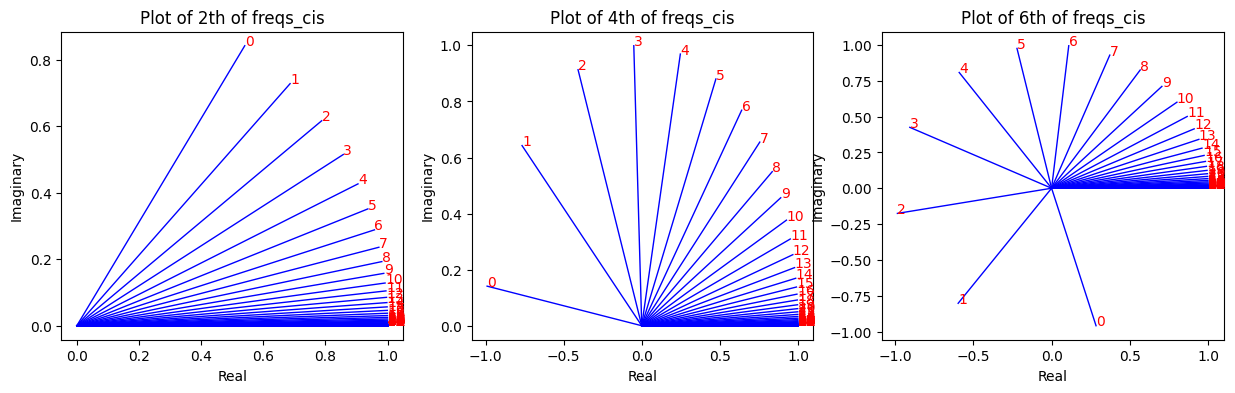

'\n注：从展示图可以看出，token位置越靠后的旋转角度越大，而单个token内的向量维度越靠前的旋转角度越大。\n    其中是否有数学上的考量可自行进一步探索X_X\n'

In [24]:
# 得到(cosmθ + sinmθi)，即将mθ转换为复数形式
# 将旋转角度mθ看做是模长为1的极坐标形式，从而将其转换为复数表示
# polar的两个输入分别表示模长（设为1，即只改变角度，不影响长度）和角度（即mθ）
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)  # [17x64] -> [17x64]
print(freqs_cis.shape)

# 查看部分位置的freqs_cis，仅展示用
token_to_show = [1, 3, 5]  # 查看第2,4,6行
fig, axs = plt.subplots(1, len(token_to_show), figsize=(5 * len(token_to_show), 4))  # 生成1行3列的3个子图图形窗口
for i, index in enumerate(token_to_show):
    value = freqs_cis[index]
    for j, element in enumerate(value):
        element = element.cpu()
        axs[i].plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {j}")  # 以实部为横坐标，虚部为纵坐标，绘制从原点到坐标点的蓝线
        axs[i].annotate(f"{j}", xy=(element.real, element.imag), color='red')  # 绘制红色的数字注释，表示第i对维度
    axs[i].set_xlabel('Real')
    axs[i].set_ylabel('Imaginary')
    axs[i].set_title(f'Plot of {index + 1}th of freqs_cis')
plt.show()

"""
注：从展示图可以看出，token位置越靠后的旋转角度越大，而单个token内的向量维度越靠前的旋转角度越大。
    其中是否有数学上的考量可自行进一步探索X_X
"""

<span style="font-size: 1.2em; font-weight: normal;">
现在我们为每个token对应的query向量元素都提供了一个复数（角度变化向量）
</span>
<br><br>
我们现在可以把我们的query（划分成对的那个）转换成复数，然后通过点积计算来旋转这些query :)

In [25]:
# 得到(x + yi)
# 即把维度对转换为复数，转换后的维度将从[17x64x2]变为[17x64]
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # [17x64x2] -> [17x64]
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [26]:
# 计算(x + yi) * (cosmθ + sinmθi)
# 即执行旋转操作，得到最终结果
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis  # [17x64] * [17x64] = [17x64]
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

<span style="font-size: 1.2em; font-weight: normal;">
获得旋转后的向量（形状复原）
</span>
<br><br>
我们可以再次将复数表示为实数，从而获得维度对形式的query结果

In [27]:
# 将复数结果还原回实数的维度对形式
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # [17x64] -> [17x64x2]
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

对旋转后的维度进行合并，这样我们就有了新的query向量（旋转后的query向量），其形状为[17x128]，其中17是token数量，128是query向量的维度

In [28]:
# 将维度对结果还原回原始query向量形式
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # [17x64x2] -> [17x128]
q_per_token_rotated.shape

torch.Size([17, 128])

#### 给key向量也添加位置信息（和query向量过程一样）

In [29]:
# 将key向量在维度方向上两两切分，形成维度对（修改形状）
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # [17x128] -> [17x64x2]
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [30]:
# 得到(x + yi)
# 即将维度对转换为复数形式
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # [17x64x2] -> [17x64]
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [31]:
# 得到(x + yi) * (cosmθ + sinmθi)，即旋转位置编码后的最终结果
# 并将结果还原回实数形式
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)  # [17x64] * [17x64] = [17x64] -> [17x64x2]
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [32]:
# 将维度对还原回原始key向量形式，得到最终的key向量
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # [17x64x2] -> [17x128]
k_per_token_rotated.shape

torch.Size([17, 128])

<span style="font-size: 1.2em; font-weight: normal;">
到了这个阶段，我们就有了每个token对应的旋转后的query向量和key向量了~
</span>

<div>
    <img src="images/keys0.png" width="600px"/>
</div>

每个query和key向量的形状仍然还是 [17x128]. 

### 万事俱备，我们开始计算token间的注意力权重

这将涉及三步过程：
1. 计算注意力分数：score = Q x K
2. 屏蔽未来token部分：score = mask(score)
3. 计算注意力权重：res = softmax(score)

我们开始吧 :)

#### 把query和key向量相乘得到注意力分数

这样我们将得到每个token和其他token之间的分数值映射
<br>
这个分数描述了每个token的query与每个token的key之间的相关程度
<br>
这就是自注意力！
<br>
这个注意力分数矩阵（qk_per_token）的形状为[17x17]，其中17是输入的prompt的token数量

<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [33]:
# 计算注意力分数
# 同时进行归一化，防止后续softmax计算结果过于偏向0或1（维度较大时的点积值可能过大），而导致梯度消失或梯度爆炸，以维持数值稳定性
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5  # [17x128] x [128x17] = [17x17]
qk_per_token.shape

torch.Size([17, 17])

#### 我们现在必须屏蔽掉未来的query-key分数

在llama3的训练过程中，未来token的qk分数会被屏蔽
<br>
为什么？因为训练过程中，我们只学习如何利用过去的token来预测当前token，如果不屏蔽未来的token，则会导致预测信息的泄露
<br>
因此，在推理过程中，我们也要将未来的token设置为0（保证训练和推理过程的逻辑一致性）
<br>

当然，如果你和我一样好奇了如果不进行屏蔽会发生什么，可以在学习完成后查看我在最后一节中进行的额外实验结果 (^_<)

<div>
    <img src="images/mask.png" width="600px"/>
</div>

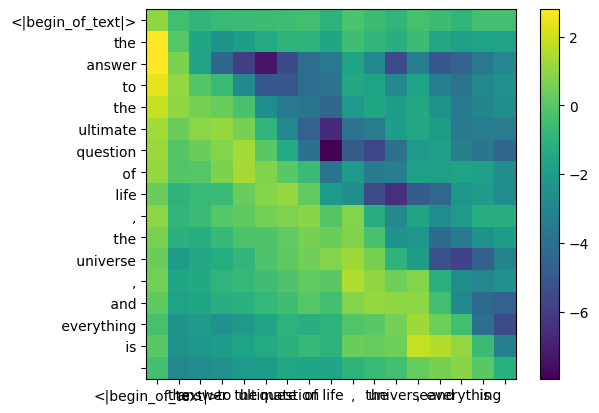

In [34]:
# 首先查看一下屏蔽前的分数矩阵
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()  # 创建图形窗口

    # imshow通常用于显示二维数组或矩阵形式的数据，将矩阵元素映射为灰度或彩色值，因此可用于绘制热力图
    # 将张量转换回全精度，然后从计算图中分离出来（detach），避免涉及到潜在的梯度计算和存储问题
    # 并指定使用viridis颜色映射方案来显示图像（蓝->绿->黄）
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')

    # 设定xy轴的刻度数量和标签，保证正确的一一对应
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)

    # 添加侧方颜色条
    # 指定im以识别正确的颜色映射和值的范围
    # 指定所属的子图为ax（若有多个子图，则ax=ax[i]）
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token)

In [35]:
# 生成屏蔽矩阵
# 让需要屏蔽的元素位置设置为负无穷，而不需要屏蔽的位置设为0，后续将其与分数矩阵相加即可实现屏蔽效果（负无穷在计算softmax时将趋于0）

# torch.full用于生成指定形状和指定填充值的张量，这里首先生成了全为负无穷的[17x17]矩阵
# 指定该矩阵位置与之前token的位置相同，以确保后续计算时不出错（例如：如果之前的token在gpu上，而这里不指定设备，则mask将新建在cpu上，二者相加时将会报错）
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)  # [17x17]

# torch.triu用于返回矩阵的上三角部分，其余部分置为0（取下三角使用torch.tril）
# diagonal为对角线的偏移量，等于1时表示从主对角线向上偏移1个位置开始取上三角部分，以避免屏蔽自身token
mask = torch.triu(mask, diagonal=1)  # [17x17]

mask, mask.shape

(tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf,

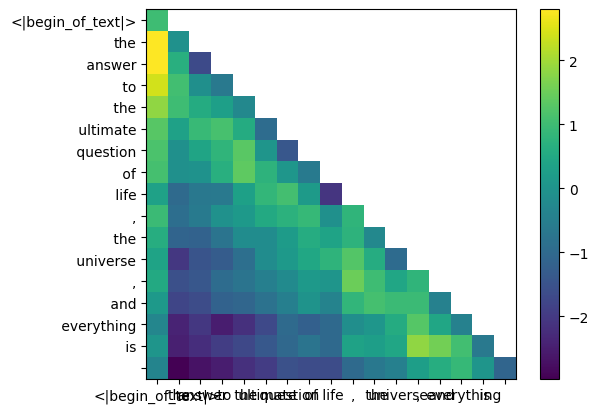

In [36]:
# 屏蔽未来token的分数
qk_per_token_after_masking = qk_per_token + mask  # [17x17] + [17x17] = [17x17]
display_qk_heatmap(qk_per_token_after_masking)  # 展示屏蔽后的注意力分数

#### 计算最终的注意力权重，即softmax(注意力分数)
<div>
    <img src="images/softmax.png" width="600px"/>
</div>

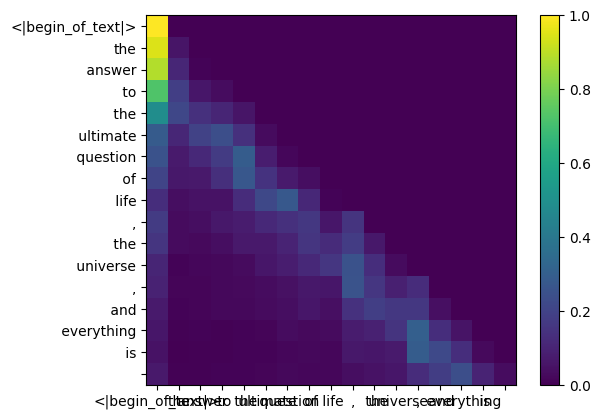

In [37]:
# 计算注意力权重
# 即计算分数的softmax值
# dim=1表示按行进行softmax的计算，结果转换为半精度，与之后的value向量保持一致
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # [17x17] -> [17x17]
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

### 终于！计算单头注意力机制的最终结果！
<div>
    <img src="images/attention.png" width="600px"/>
</div>

原理：之前的注意力权重(0-1)用于确定每个token使用多少比例的value向量（即对value向量进行加权）

例子：假如输入为3个token，则第一个token的注意力结果可能为：res=0.6\*value_1 + 0.3\*value_2 + 0.1\*value_3

经过权重矩阵和value矩阵乘法计算后的注意力结果的形状为[17x128]

In [38]:
# 计算单头注意力的最终结果
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
qkv_attention.shape

torch.Size([17, 128])

## 计算多头的注意力机制（一个简单的循环，将上面的过程重复）
<div>
    <img src="images/heads.png" width="600px"/>
</div>

我们现在有了第一层的第一个头的注意力值
<br>

现在我们要运行一个循环，来执行和之前单元格完全相同的数学过程，但是会计算第一层中的每个头
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">
值得注意的是，在<a href="https://github.com/meta-llama/llama3/blob/main/llama/model.py#L90">官方的llama3代码实现</a>中，多头注意力计算采取了一次性矩阵乘法的方式，而非费时的for循环计算，大致过程如下：
</span>

1. 基于矩阵并行，计算qkv向量，[17x4096] x [4096x4096] or [4096x1024] = [17x4096] or [17x1024]，再将形状转换为[32x17x128] or [8x17x128]
2. 得到qkv向量后，将kv内部进行复制，从而与q向量形状保持一致，此时形状均为[32x17x128]
3. 计算分数时，采用transpose方法将张量的最后两维位置交换从而完成矩阵乘法，如 `torch.matmul(q, k.transpose(1,2)) / head_dim ** 0.5`，此时为[32x17x128] x [32x128x17] = [32x17x17]
4. 其他的矩阵计算同理
<br>

注：上述过程中每一步的矩阵形状变化为简化版，仅供示意以便于理解，与llama3官方实现的变化过程不同（官方实现中会涉及大量的形状变化过程）

### 计算每个头的结果

In [39]:
# 计算多头注意力结果
# 即之前的单头注意力计算过程的循环
qkv_attention_store = []

for head in range(n_heads):
    # 取出当前头对应的qkv权重矩阵
    q_layer0_head = q_layer0[head]  # [32x128x4096] -> [128x4096]
    k_layer0_head = k_layer0[head//(n_heads // n_kv_heads)]  # 每4个头共享一个key权重，[8x128x4096] -> [128x4096]
    v_layer0_head = v_layer0[head//(n_heads // n_kv_heads)]  # 每4个头共享一个value权重，[8x128x4096] -> [128x4096]
    
    # 计算XW，得到qkv向量
    # [17x4096] x [4096x128] = [17x128]
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)
    
    # 给query向量加入位置信息（RoPE）
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
    q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis[:len(tokens)]  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # 结果还原回原始向量形状，得到最终的query向量，[17x64x2] -> [17x128]

    # 给key向量加入位置信息（RoPE）
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
    k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis[:len(tokens)]  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # 结果还原回原始向量形状，得到最终的key向量，[17x64x2] -> [17x128]

    # 计算注意力分数，同时归一化分数（即QxK/sqrt(dim)）
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5  # [17x128] x [128x17] = [17x17]
    
    # 屏蔽未来token的分数
    mask = torch.full(qk_per_token.shape, float("-inf"), device=tokens.device)  # 创建和注意力分数相同形状，值全为负无穷的矩阵，并保证存储位置和其他向量一致，防止后续计算时错误，[17x17]
    mask = torch.triu(mask, diagonal=1)  # 保留上三角部分的负无穷，将下三角设为0（即上三角区域为未来token需要屏蔽，下三角为当前及以前的token无需屏蔽），对角线偏移量为1，避免屏蔽自身token，[17x17]
    qk_per_token_after_masking = qk_per_token + mask  # 注意力分数与屏蔽矩阵相加，使分数矩阵的上三角变为负无穷，后续softmax后将趋于0，[17x17]
    
    # 计算注意力权重（即softmax(score)）
    # 同时变换回半精度（因为后续要和value向量v_per_token相乘，需要保证数据类型相同）
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # 按行计算softmax，[17x17]
    
    # 计算注意力机制的最终结果（即softmax(score) x v）
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
    
    # 记录该头结果
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

### 合并每个头的结果为一个大矩阵

<div>
    <img src="images/stacked.png" width="600px"/>
</div>
现在我们有了第一层所有的32个头的注意力机制结果，下一步我们将合并所有的注意力值到一个大的矩阵，形状为[17x4096]
<br>
我们注意力层的计算马上就要到头了 :)

In [40]:
# 合并多头注意力矩阵
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)  # 将第二维合并，即32个[17x128] -> [17x4096]
stacked_qkv_attention.shape

torch.Size([17, 4096])

### 头间信息交互（线性映射），自注意力层的最后一步！
<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>
对于layer0的attention计算的最后一步是进行最后一次的线性映射，也就是将合并的注意力矩阵与输出权重矩阵相乘

In [41]:
# 加载layers.0的output权重矩阵
w_layer0 = model["layers.0.attention.wo.weight"]  # [4096x4096]
w_layer0.shape

torch.Size([4096, 4096])

这只是一个简单的线性层，所以我们只需要矩阵乘法即可

In [42]:
# 进行注意力矩阵的线性映射
# 这就是注意力层的最终输出结果了
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)  # [17x4096] x [4096x4096] = [17x4096]
embedding_delta.shape

torch.Size([17, 4096])

## 进行一下残差操作（add）

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>
现在我们有了输入向量在进行注意力机制作用后的值，这时要在它的身上添加原始的输入向量（即残差操作，保证信息的不易丢失，并缓解梯度消失问题）

In [43]:
# 将attention层的输出与原始输入相加，完成残差操作
embedding_after_edit = token_embeddings_unnormalized + embedding_delta  # [17x4096] + [17x4096] = [17x4096]
embedding_after_edit.shape

torch.Size([17, 4096])

## 进行第二次的归一化操作
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [44]:
# 将残差结果再进行一下归一化
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

## 进行ffn前馈网络层的计算
<div>
    <img src="images/swiglu.png" width="600px"/>
</div>
<br>
在llama3中，它们使用了SwiGLU前馈网络，这种网络架构可以在模型需要时很好的增加非线性特性
<br>
如今，这种前馈网络架构在大模型中很常用
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">为什么要引入非线性层：</span>

- 非线性特性是神经网络模型能成为“万能函数逼近器”的核心。在传统神经网络模型中，我们要使用非线性的激活函数（如sigmoid，ReLU等）来增加模型的表达能力，使其能够拟合训练数据中隐含的复杂模式。
- 而在transformer中，由于注意力机制本质上是对value向量的线性加权求和（尽管权重是经由softmax函数的非线性计算得到的，但对value来说依旧只是线性加权），因此它虽然能够捕捉全局依赖，但其输出仍只是输入的线性组合，此时的transformer模型是缺乏非线性能力的。
- 因此，需要在自注意力层后添加FFN网络，给模型引入非线性变换能力，从而提升模型能够对复杂语义关系进行建模的能力。
<br>

<span style="font-size: 1.2em; font-weight: bold;">大致来说，引入非线性层可以起到如下作用：</span>

1. 给模型增加非线性能力以便于模型的学习训练
2. 增加模型的信息抽象能力，使模型在逐层的学习过程中，能够表征不同层面的数据特征和模式，比如低层网络识别基础的语言结构（如词性），而在高层则能够理解更为复杂的语义信息（如情感、意图）
3. 此外，目前的一种观点认为，注意力层主要用于输入上下文的交互，而FFN层才是大模型中主要记忆存储训练时的通用知识的地方（得益于其非线性表征能力），从而能够从通用知识中找到输入问题的答案
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">SwiGLU网络结构：</span>

1. 将输入进行线性变换：$X^\prime = XW_3$
2. 门控单元：$GATE = Activation\_Function(XW_1)$，用于有选择的通过信息，即假定 $X^\prime$ 中的信息重要性不同，从而通过门控单元的分数对信息进行加权通过，进而提升模型的表达能力
3. 其中的激活函数为一种Swish激活函数（因此网络称为SwiGLU，即Swish激活函数和GLU门控线性单元的结合），公式为：$Swish = X \cdot \sigma(\beta X)$，其中 $\sigma$ 为sigmoid激活函数，在SwiGLU中，$\beta$为1（在原始公式里是一个可学习参数）
4. 因此，门控单元的具体计算为：$GATE = XW_1 \cdot \sigma(XW_1)$，在pytorch中，该激活函数为silu，即 $GATE = silu(XW_1)$
5. 门控机制应用：$X^\prime = X^\prime \cdot GATE$
6. 再次进行线性变换：$Y = X^\prime W_2$
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">前馈层隐藏层维度大小的来源计算（基于llama3官方实现过程）：</span>

1. 输入维度dim = 4096
2. hidden_dim = 4 * dim = 16384  # 首先放大四倍，在transformer块中初始化前馈层时，输入hidden_dim时乘了四倍
3. hidden_dim = int(2 * hidden_dim / 3) = 10922 # 再放大2/3倍，在前馈层内首先进行了这样的放缩
4. hidden_dim = int(ffn_dim_multiplier * hidden_dim) = int(1.3 * 10922) = 14198  # 再放大ffn_dim_multiplier倍，在模型配置文件中定义了ffn_dim_multiplier为1.3
5. hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of) = 1024 * ((14198 + 1024 - 1) // 1024) = 14336  # 调整为multiple_of的整数倍，在模型配置文件中定义了multiple_of为1024，确保模型所有隐藏层维度都是1024的倍数，以提升计算效率
6. 最终便得到了隐藏层为14336维的结果

In [45]:
# 计算前馈网络层
# 隐藏层维度大小为14336
w1 = model["layers.0.feed_forward.w1.weight"]  # [14336x4096]
w3 = model["layers.0.feed_forward.w3.weight"]  # [14336x4096]
w2 = model["layers.0.feed_forward.w2.weight"]  # [4096x14336]
print(w1.shape, w3.shape, w2.shape)

# output = (silu(XW1) * XW3)W2
# [17x4096] x [4096x14336] x [14336x4096] = [17x4096]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([14336, 4096]) torch.Size([14336, 4096]) torch.Size([4096, 14336])


torch.Size([17, 4096])

## 再次进行一下残差操作（终于得到transformer块的最终输出了！）

In [46]:
# 将前馈层的输出与原始输入相加，完成残差操作
# 这就是一个transformer块的最终结果了
layer_0_embedding = embedding_after_edit+output_after_feedforward  # [17x4096] + [17x4096] = [17x4096]
layer_0_embedding.shape

torch.Size([17, 4096])

<span style="font-size: 1.5em; font-weight: normal;">
我们终于有了每个token在经过第一层之后的新的嵌入向量
</span>
<br><br>
距离完成只剩31层了（只差一个for循环）
<br>
你可以设想，这个经过处理后的嵌入向量包含了在第一层中所提出的所有token的信息
<br>
现在，每一层都会对所提出的问题中的更复杂query进行编码，一直到最后，我们会得到一个嵌入向量，它知道我们所需的下一个token的所有信息

# 一切都在这了，让我们完成全部的32层transformer块的计算，阅读愉快 :)
<div>
    <img src="images/god.png" width="600px"/>
</div>

是的，就是这样。所有我们之前所做的，都将一次性在这里全部呈现，以完成每一层的计算。
<br>

In [47]:
# 现在开始完成全部的32层transformer块的计算！

# 输入token的嵌入向量作为初始值
final_embedding = token_embeddings_unnormalized  # [17x4096]

# 32层transformer块逐层计算
for layer in range(n_layers):
    #########################################################################################################################
    ###################################### 第一轮 归一化-特征变换-残差 ######################################################
    
    ########################### 第一次归一化 ###################################################
    
    # 第一次归一化
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
    
    ########################### 第一次特征变换-多头自注意力 #####################################
    
    # 获取当前层注意力机制的qkv权重矩阵
    q_layer = model[f"layers.{layer}.attention.wq.weight"]  # [4096x4096]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)  # [32x128x4096]
    k_layer = model[f"layers.{layer}.attention.wk.weight"]  # [1024x4096]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)  # [8x128x4096]
    v_layer = model[f"layers.{layer}.attention.wv.weight"]  # [1024x4096]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)  # [8x128x4096]
    
    # 用于存储每个头的注意力机制计算结果
    qkv_attention_store = []
    
    # 计算每个头的注意力机制结果
    for head in range(n_heads):
        # 取出当前头的qkv权重矩阵
        q_layer_head = q_layer[head]  # [32x128x4096] -> [128x4096]
        k_layer_head = k_layer[head//(n_heads // n_kv_heads)]  # 每4个头共享一个key权重，[8x128x4096] -> [128x4096]
        v_layer_head = v_layer[head//(n_heads // n_kv_heads)]  # 每4个头共享一个value权重，[8x128x4096] -> [128x4096]
        
        # 计算XW，得到输入token的qkv向量
        # [17x4096] x [4096x128] = [17x128]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        
        # 给query向量加入位置信息（RoPE）
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
        q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # 结果还原回原始向量形状，得到最终的query向量，[17x64x2] -> [17x128]
        
        # 给key向量加入位置信息（RoPE）
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
        k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # 结果还原回原始向量形状，得到最终的key向量，[17x64x2] -> [17x128]
        
        # 计算注意力分数，同时归一化分数（即QxK/sqrt(dim)）
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5  # [17x128] x [128x17] = [17x17]
        
        # 屏蔽未来token的分数
        mask = torch.full(qk_per_token.shape, float("-inf"), device=qk_per_token.device)  # 创建和注意力分数相同形状，值全为负无穷的矩阵，并保证存储位置和其他向量一致，防止后续计算时错误，[17x17]
        mask = torch.triu(mask, diagonal=1)  # 保留上三角部分的负无穷，将下三角设为0（即上三角区域为未来token需要屏蔽，下三角为当前及以前的token无需屏蔽），对角线偏移量为1，避免屏蔽自身token，[17x17]
        qk_per_token_after_masking = qk_per_token + mask  # 注意力分数与屏蔽矩阵相加，使分数矩阵的上三角变为负无穷，后续softmax后将趋于0，[17x17]
        
        # 计算注意力权重（即softmax(score)）
        # 同时变换回半精度（因为后续要和value向量v_per_token相乘，需要保证数据类型相同）
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # 按行计算softmax，[17x17]
        
        # 计算注意力机制的最终结果（即softmax(score)xV）
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
        
        # 记录该头结果
        qkv_attention_store.append(qkv_attention)
    
    # 合并多头注意力结果
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)  # 将第二维合并，即32个[17x128] -> [17x4096]
    
    # 结果做线性映射，生成最终的多头自注意力机制结果
    o_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, o_layer.T)  # [17x4096] x [4096x4096] = [17x4096]
    
    ########################### 第一次残差连接 ################################################
    
    # 第一次残差
    # 将attention层的输出与原始输入相加，完成残差操作
    embedding_after_edit = final_embedding + embedding_delta  # [17x4096] + [17x4096] = [17x4096]
    
    
    #########################################################################################################################
    ###################################### 第二轮 归一化-特征变换-残差 ######################################################
    
    ########################### 第二次归一化 ###################################################
    
    # 第二次归一化
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
    
    ########################### 第二次特征变换-前馈神经网络 #####################################
    
    # 加载前馈网络（SwiGLU）参数矩阵
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]  # [14336x4096]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]  # [14336x4096]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]  # [4096x14336]
    
    # 计算前馈网络结果（output = (silu(XW1) * XW3)W2）
    # [17x4096] x [4096x14336] x [14336x4096] = [17x4096]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    
    ########################### 第二次残差连接 ##################################################
    
    # 第二次残差，得到当前transformer块的最终输出结果
    # 将前馈层的输出与原始输入相加，完成残差操作
    final_embedding = embedding_after_edit+output_after_feedforward  # [17x4096] + [17x4096] = [17x4096]

# 让我们完成最后一步，预测下一个token

现在我们得到了最终的嵌入向量，这个嵌入向量中包含了预测下一个token所需的全部信息
<br>
这个嵌入向量的形状和输入时的token嵌入向量形状相同，均为[17x4096]，其中17为token的数量，4096是嵌入向量的维度

<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

## 首先对最后一层transformer的输出进行最后一次的归一化

In [48]:
# 进行整个模型中最后一次的归一化
final_embedding = rms_norm(final_embedding, model["norm.weight"])  # [17x4096] & [4096] -> [17x4096]
final_embedding.shape

torch.Size([17, 4096])

## 然后基于最后一个token对应的嵌入向量进行预测（线性映射到词典维度）

<div>
    <img src="images/finallayer.png" width="600px"/>
</div>

<br>
我们将使用输出解码器（一个线性映射层）来将最后一个token的嵌入向量转换成对下一个token的预测结果（词典维度大小，如果将结果再进行一下softmax，则每一维的值即代表下一个token属于该词的概率）
<br><br>

为什么只选取最后一个token对应的输出向量来进行下一个token的预测？
<br>
因为模型在训练时的目标为基于当前token及以前的信息，预测下一个token，因此，每一个token对应的输出向量都是在预测相对于它自己的下一个token，而非整个输入的下一个token
<br><br>

希望在我们的例子中是42 :)
<br>
注：42是“the answer to the ultimate question of life, the universe, and everything is ”（“关于生命，宇宙和一切事情的终极答案是：”）的答案，根据“银河系漫游指南”这本书，大多数的现代大模型都会回答42，这将验证我们的整个代码的正确性！祝我们好运 :)

In [49]:
# 最后一次的线性映射，将嵌入向量映射成词典维度大小，以作为对下一个token的预测
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)  # [17x4096] -> [4096] -> [4096] x [4096x128256] = [128256]
logits.shape

torch.Size([128256])

## 预测结果来咯

In [50]:
# 取出概率最大的那一维对应的id，即预测的下一个token的id
next_token = torch.argmax(logits, dim=-1)  # 获取最大值对应的下标，即预测的下一个token id，[128256] -> [1]
next_token

tensor(2983)

In [51]:
# 基于预测的id，还原回具体预测的值
tokenizer.decode([next_token.item()])

'42'

<div>
    <img src="images/42.png" width="600px"/>
</div>

# 让我们扩展一下，看看使用不同的嵌入或未来token屏蔽策略会对预测结果产生什么影响 :)

现在我们已经得到了最终的预测结果，如果你还感兴趣的话，和我一起再了解一些之前可能提到了的问题吧~
<br>

我们会简单探究一下三种情况：
1. 当前预测结果除了top-1，还预测了些什么，即top-k的结果
2. 如果使用其它token的嵌入向量来做预测，能够预测到什么
3. 如果在当初的attention计算时，没有屏蔽未来token，那么预测结果会有什么样的不同

In [52]:
# 让我们先看一下top-k的预测结果
logits_sort, logits_idx = torch.sort(logits, dim=-1, descending=True)  # 对预测结果做排序，使最大可能性的预测token放前面，[128256]
[tokenizer.decode([i]) for i in logits_idx[:10]]  # 查看前10大概率的结果

['42', '6', '43', '41', '4', '1', '45', '3', '2', '46']

In [53]:
# 让我们再试一下用其他token的嵌入向量做预测能得到什么
logits_all_token = torch.matmul(final_embedding, model["output.weight"].T)  # 将嵌入向量映射成词典大小的维度，[17x4096] x [4096x128256] = [17x128256]
logits_all_token_sort, logits_all_token_idx = torch.sort(logits_all_token, dim=-1, descending=True)  # 对预测结果做排序，使最大可能性的预测token放前面，[17x128256]

print('输入的token：', prompt_split_as_tokens)  # 展示输入的token，[17]

# 展示基于每个token的嵌入向量所做的下一个token预测的结果
for i in range(len(final_embedding)):
    print(f'基于第{i+1}个token的嵌入向量的预测结果：', [tokenizer.decode([j]) for j in logits_all_token_idx[i][:10]])  # 输出前10大概率的结果
    
_="""
可以看到的是，基于每个token进行预测时，其预测结果为当前token后的下一个token的可能结果，而不是整个完整输入的预测结果，因此在实际预测时，会只使用最后一个token的嵌入向量来做预测
"""

输入的token： ['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
基于第1个token的嵌入向量的预测结果： ['Question', 'def', '#', 'The', 'import', 'Tags', 'A', 'package', 'Home', 'I']
基于第2个token的嵌入向量的预测结果： [' ', ' best', ' first', ' most', ' new', ' world', ' last', ' same', ' way', ' number']
基于第3个token的嵌入向量的预测结果： [' to', ' is', ' was', ' of', ' lies', ',', ' for', ' you', ' key', ' will']
基于第4个token的嵌入向量的预测结果： [' the', ' this', ' your', ' all', ' that', ' a', ' my', ' life', ' "', ' everything']
基于第5个token的嵌入向量的预测结果： [' question', ' problem', ' above', ' ultimate', ' first', ' r', ' following', ' questions', ' most', ' previous']
基于第6个token的嵌入向量的预测结果： [' question', ' questions', ' mystery', '\xa0', ' quest', '\n', ' life', ' philosophical', ' qu', ' problem']
基于第7个token的嵌入向量的预测结果： [' of', '\n', ' to', ' is', '?\n', ',', '.\n', ':', '...\n', ' about']
基于第8个token的嵌入向量的预测结果： [' life', ' Life', ' th

In [54]:
# 最后，我们看一下如果在计算attention时不屏蔽未来token，预测结果会变成什么
# 此时基于每个token的预测结果将变为如下所示
# 可以看到，由于未来token的可见性，基于每个token的嵌入向量都将更准确的预测出“对于它来说的”下一个token（有一点点“作弊”了）

_="""
输入的token： ['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
基于第1个token的嵌入向量的预测结果： ['://', '.Forms', '_REF', ' Angeles', '.swing', '�', 'php', 'во', 'ysics', '�']
基于第2个token的嵌入向量的预测结果： [' answer', ' Hitch', ' universe', ' question', ' ultimate', ' meaning', ' hitch', ' Universe', ' Answer', ' reason']
基于第3个token的嵌入向量的预测结果： [' to', ' is', ',', ':', ' was', '\n', ' ', ' (', '\n\n', ' of']
基于第4个token的嵌入向量的预测结果： [' the', ' life', ' this', ' which', ' everything', ' that', ' how', ' why', ' ', ' all']
基于第5个token的嵌入向量的预测结果： [' ultimate', ' question', ' great', ' meaning', ' universe', ' Ultimate', ' everything', ' life', ' holy', ' greatest']
基于第6个token的嵌入向量的预测结果： [' question', ' answer', ' is', ' was', '\n', ' questions', ' mystery', '\n\n', ' what', ' Question']
基于第7个token的嵌入向量的预测结果： [' of', ' is', '\n', ',', ' about', ':', ' to', ' in', ' (', '<|end_of_text|>']
基于第8个token的嵌入向量的预测结果： [' life', ' existence', ' everything', ' Life', ' the', ' death', ' time', ' all', ' why', ' which']
基于第9个token的嵌入向量的预测结果： [',', ' is', ' the', '\n', ':', ' (', '...', ' and', ' ,', ' -']
基于第10个token的嵌入向量的预测结果： [' the', ' and', ' is', ' death', ' The', ' which', ' or', '\xa0', ' existence', ' don']
基于第11个token的嵌入向量的预测结果： [' universe', ' answer', ' cosmos', ' world', ' existence', ' Universe', ' everything', ' un', ' meaning', ' question']
基于第12个token的嵌入向量的预测结果： [',', ' and', ' is', ' &', '\n', ' ,', '.', '...', ' (', ' ']
基于第13个token的嵌入向量的预测结果： [' and', ' &', ' don', ' the', ' is', ' a', ' or', ' Douglas', '\xa0', '<|end_of_text|>']
基于第14个token的嵌入向量的预测结果： [' everything', ' dough', ' don', ' ever', ' deep', ' Douglas', ' the', ' every', ' all', ' death']
基于第15个token的嵌入向量的预测结果： ['\n', ' is', ',', '.', ' ', ' (', ':', '<|end_of_text|>', '\n\n', '.\n']
基于第16个token的嵌入向量的预测结果： [' ', '\n', ' forty', '...', ' "', '42', ' the', ':', '\xa0', ' to']
基于第17个token的嵌入向量的预测结果： ['42', '6', '4', '41', '1', '2', '3', '7', '5', '43']
"""

# 需要预测多个token？使用KV-Cache吧（梳理清楚这个真的花费了我好大的精力 Orz）


<span style="font-size: 1.5em; font-weight: bold;">如何连续预测多个token</span>

现在，我们完成了针对输入文本的下一个词的预测，但是，如果我们预期的输出需要多个token呢？
<br>
比如在实际的大模型应用中，大模型通常不会只输出一个词，而通常是一段文本，甚至是非常长的文本输出，这一能力是如何实现的呢？
<br>
其实很简单，只需要反复调用大模型的预测过程，就可以逐步生成完整的句子或段落。
<br>
这个过程就像“滚雪球”，每次预测一个词，就将这个词加入到当前的输入序列中，然后重新调用大模型进行新一轮的预测，直到遇到停止符（在llama3中是一个特殊token “<|end_of_text|>”），或达到最大长度限制（一个超参数 max_seq_len）后，停止预测。
<br><br>
这样听起来效率好低？是的！
<br>
因此就有了比如KV-Cache这一耳熟能详的缓存机制，通过缓存历史token的KV向量，来减少输入及计算量，从而提升推理效率。
<br>
得益于缓存机制，当我们使用大模型进行推理时，你可能会发现往往在等待第一个token输出时是最漫长的，而一旦输出了第一个token，后续token的输出速度将大大提高。
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">KV-Cache的优劣势</span>

**优势**：持续预测时，每次只需要输入新的token即可，无需将完整的文本序列全部输入进来，从而极大提升推理时计算速度
<br>
**劣势**：由于缓存机制的存在，在推理时会额外占用较多的内存资源
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">KV-Cache的原理推导</span>

KV-Cache来自于对上述矩阵计算过程的观察和分析，通过分析每个输入token在其中的计算过程，我们可以发现在大多数的计算步骤中，每个token的计算其实都是相对独立的，很少涉及到与其他token的交互，而只有计算注意力机制时会涉及到token间的交互，因此会需要历史KV向量的缓存。
<br>

<span style="font-size: 1.2em; font-weight: bold;">以下是KV-Cache的具体推导逻辑：</span>
1. **前提**：预测下一词只需要得到最后一个token的输出结果（正如我们在预测章节所做的一样）
2. **非注意力部分只需计算新token**：除了注意力计算以外，所有部分的计算都是token间相互独立的，因此只需要计算新token即可，可以不用输入历史token（我将在下面进行展开分析）
3. **注意力部分也只需计算新token**：注意力层中，由于屏蔽机制的存在，历史token的输出结果不会受未来新token的影响，因此其在每一层的输入和输出都是固定不变的，即历史token的QKV向量都不会因为加入新token而改变，从而只需要计算新token的注意力即可
4. **新token注意力机制计算**：注意力层用来让token获取历史token的上下文信息，所以需要为每个新token都使用全部token的value向量进行加权和，因此需要存储历史token的value
5. **新token注意力权重计算**：由第4条可知，我们还需要先获取新token与历史token间的重要性信息，即权重，所以需要计算新token与所有token的key向量乘积，因此需要存储历史token的key
6. **KV-Cache的获取**：由第4,5条可知，我们需要存储历史token的KV向量，而query向量因为没有用到，所以不用存储，这就是KV-Cache的由来
7. **KV-Cache的高效性**：由第3条可知，历史KV向量是不会变化的，因此可以在持续预测过程中不断的增量更新，而无需修改历史内容。这样，每次预测时只需要输入并计算新增token的结果，而无需将完整序列作为输入，从而大幅提升推理效率
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">注：KV-Cache中token计算的独立性分析</span>

**除注意力层以外的所有组件（均无交互）**：
1. **两次归一化(normalization)**：每个token向量都是在自己的特征维度上进行归一化计算，不会用到其它token
2. **两次残差连接(add)**：每个token向量都是将自己的输出结果与自己相加，也不会用到其它token
3. **前馈网络(FFN)**：每个token向量分别乘以相同的权重矩阵W1，W2，W3得到结果，其间也不会用到其它token。可以设想，假如输入token数为17，则FFN的计算可以简化为：[17x4096] x [4096x14336] x [14336x4096] = [17x4096]，这其实等价于每次输入一个token，然后将17个结果拼接成一个矩阵，即：17次([1x4096] x [4096x14336] x [14336x4096] = [1x4096]) = 17x[1x4096] => [17x4096]。因此，每个token在前馈层中计算时，其实和其他token也没有交互

**注意力层（新token与历史token只有单向交互）**：
1. **计算QKV向量**：每个token向量乘以相同的QKV权重矩阵得到结果，不会用到其它token
2. **QK向量添加位置信息**：每个token向量以自身位置为基础进行独立的旋转操作，不会用到其它token的具体内容
3. **计算注意力权重**：注意力权重代表每个token与它之前的每个历史token的相关性，而与未来token无关，因此历史token结果独立于新token。而新token需要历史token的key向量缓存
4. **计算注意力机制结果**：注意力机制基于注意力权重进行value向量的加权和，因此和上一条的结论一样，历史token结果独立于新token。而新token需要历史token的value向量缓存
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">基于KV-Cache的注意力计算过程</span>

为了清晰展示计算过程，仅推导单头场景（推广至多头场景的原理和过程与之前的多头注意力实现是完全一致的）：
1. 假设历史输入token为$S_1$，长度为N，则基于KV-Cache，将存储每个头的KV结果矩阵，单个头的形状为 [Nxhead_dim] = [Nx128]
2. 假设新增输入token为$S_2$，长度为M（可以是新预测的token，也可以是用户新一轮对话的输入等各种场景）
3. 计算新token的QKV向量：$Q,K,V = S_2W_{Q,K,V}$ => [Mx4096] x [4096x128] = [Mx128]
4. 给QK向量加入位置信息：新token的位置要从N+1开始算起，不能从0计算，[Mx128] -> [Mx128]
5. 将新的KV值加入到KV缓存中，得到更新后的KV矩阵，即 [Nx128] -> [(N + M)x128]
6. 计算新token的注意力权重：Attention_weight = softmax(QK/sqrt(d) + mask) => [Mx128] x [128x(N + M)] = [Mx(N + M)]
7. 计算新token的注意力机制最终结果：Attention_weight x V => [Mx(N + M)] x [(N + M)x128] = [Mx128]
8. 将每个头的结果做拼接并线性映射后，得到最终的注意力层输出，形状为 32x[Mx128] -> [Mx4096]
<br><br>


鉴于我们之前的学习过程已经很完整了，这里便不再进行优化方案的代码实现（感兴趣可以看llama3的官方代码，实现还是比较简单的）。就像之前提到的多头注意力的并行计算一样，知道计算过程是可以优化的就可以了~

# 感谢各位，辛苦你们的一路学习，爱你们 :)

我们的学习结束了，希望你们同样享受了这个阅读过程！

## From Me

如果你看到了这个工作，感谢你的信任和一路学习到这里，很高兴能够帮助到你~

如果你想支持我的工作
1. 点个star⭐吧~ :) 
2. 请我一杯咖啡~ [https://ko-fi.com/therealoliver](https://ko-fi.com/therealoliver)

<br>

## From前身项目作者

如果你想支持我的工作：

1. 订阅我的twitter https://twitter.com/naklecha 
2. 或者请我一杯咖啡吧 [https://www.buymeacoffee.com/naklecha](https://www.buymeacoffee.com/naklecha)

说真的，你们学习到了这里，就已经让我很开心了 :)

是什么在激励我做这件事？

是我和我的朋友在执行一项使命 - 让研究变得更加触手可及！
我们创建了一个研究实验室，叫做A10 - [AAAAAAAAAA.org](http://aaaaaaaaaa.org/)

A10的twitter - https://twitter.com/aaaaaaaaaaorg

我们的论点：
<div>
    <img src="images/a10.png" width="600px"/>
</div>
<br><br>
再次感谢原作者的基础代码和图例，也让我学到了很多

# LICENSE

Copyright (c) 2025 Jinlong Zhang (https://github.com/therealoliver)

Copyright (c) 2024 Nishant Aklecha

MIT